In [57]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import numpy as np


In [58]:
np.random.seed(42)

In [59]:
sp500 = yf.Ticker("RELIANCE.NS")
sp500 = sp500.history(period="max")

In [60]:
sp500.index = pd.to_datetime(sp500.index)

In [61]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1996-01-01 00:00:00+05:30,4.618591,4.643373,4.588176,4.635488,104121369,0.0,0.0
1996-01-02 00:00:00+05:30,4.624224,4.646754,4.565647,4.599441,168743308,0.0,0.0
1996-01-03 00:00:00+05:30,4.674915,4.887821,4.624224,4.634362,209323879,0.0,0.0
1996-01-04 00:00:00+05:30,4.590429,4.605073,4.529599,4.591556,216900264,0.0,0.0
1996-01-05 00:00:00+05:30,4.573533,4.573533,4.520588,4.560015,166708467,0.0,0.0
...,...,...,...,...,...,...,...
2025-07-07 00:00:00+05:30,1526.599976,1544.800049,1525.000000,1541.500000,7251074,0.0,0.0
2025-07-08 00:00:00+05:30,1536.000000,1544.900024,1530.199951,1537.599976,7171261,0.0,0.0
2025-07-09 00:00:00+05:30,1536.699951,1551.000000,1510.099976,1519.000000,8870660,0.0,0.0


<Axes: xlabel='Date'>

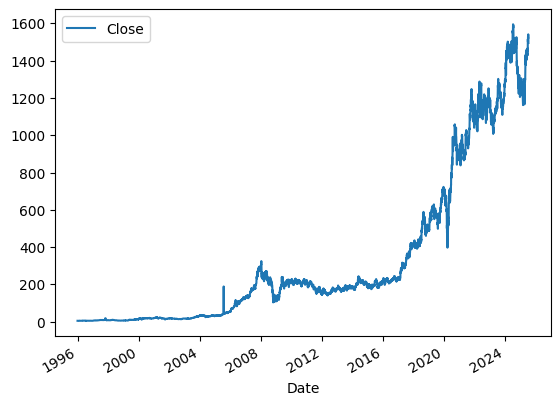

In [62]:
sp500.plot.line(y="Close", use_index=True)

In [63]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [64]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [65]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [66]:
sp500 = sp500.loc["1990-01-01":].copy()

In [67]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [68]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [69]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [70]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [71]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1999-11-01 00:00:00+05:30,12.420323,12.467871,11.445611,11.509007,114373142,12.378063,1,0.961174,0.0,0.905069,0.0,1.042669,27.0,1.380827,116.0,1.619984,458.0
1999-11-02 00:00:00+05:30,11.358444,12.430893,11.226369,12.378063,129022957,11.910517,0,1.036382,1.0,0.990782,1.0,1.115980,28.0,1.480621,116.0,1.740405,459.0
1999-11-03 00:00:00+05:30,12.700324,12.700324,11.744103,11.910517,175844467,11.944854,1,0.980750,1.0,0.974708,1.0,1.069273,28.0,1.420777,115.0,1.672955,458.0
1999-11-04 00:00:00+05:30,11.825986,12.174663,11.680704,11.944854,122838876,12.282966,1,1.001439,1.0,0.992406,2.0,1.067558,29.0,1.420869,116.0,1.676047,459.0
1999-11-05 00:00:00+05:30,11.939571,12.457306,11.939571,12.282966,131084769,12.282966,0,1.013956,2.0,1.023147,3.0,1.092182,30.0,1.456768,116.0,1.721623,460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-07 00:00:00+05:30,1526.599976,1544.800049,1525.000000,1541.500000,7251074,1537.599976,0,1.004627,2.0,1.009654,3.0,1.091173,36.0,1.132849,128.0,1.251307,519.0
2025-07-08 00:00:00+05:30,1536.000000,1544.900024,1530.199951,1537.599976,7171261,1519.000000,0,0.998733,1.0,1.005888,2.0,1.083908,35.0,1.130135,127.0,1.247614,519.0
2025-07-09 00:00:00+05:30,1536.699951,1551.000000,1510.099976,1519.000000,8870660,1517.199951,0,0.993915,0.0,0.993694,2.0,1.067034,34.0,1.116715,126.0,1.232011,519.0


In [72]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [73]:
predictions = backtest(sp500, model, new_predictors)

In [74]:
predictions["Predictions"].value_counts()

Predictions
0.0    3589
1.0     324
Name: count, dtype: int64

In [75]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5339506172839507

In [76]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.507283
0    0.492717
Name: count, dtype: float64

In [77]:
predictions

,Target,Predictions
Date,,
2009-09-01 00:00:00+05:30,0,0.0
2009-09-02 00:00:00+05:30,0,0.0
2009-09-03 00:00:00+05:30,1,0.0
2009-09-04 00:00:00+05:30,1,0.0
2009-09-07 00:00:00+05:30,1,0.0
...,...,...
2025-07-07 00:00:00+05:30,0,0.0
2025-07-08 00:00:00+05:30,0,0.0
2025-07-09 00:00:00+05:30,0,0.0


In [1]:
%pip install prophet

^C
Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 359.4 kB/s eta 0:00:36
   - -------------------------------------- 0.5/13.3 MB 359.4 kB/s eta 0:00:36
   -- ------------------------------------- 0.8/13.3 MB 459.4 kB/s eta 0:00:28
   --- ------------------------------------ 1.0/13.3 MB 542.9 kB/s eta 0:00:23
   --- ------------------------------------ 1.3/13.3 M